# Drive Performance EDA and Model
In this notebook, I will explore the relationships of different player stats and their expected value on future drives.  

Goals:
- Look for what stats might best predict drive performance.
- Find the best model to make accurate predictions.

Conclusions:  
- The increase in sample size from post-ups was not very helpful.
- Passing ability was again an important predictor.
- Scoring ability on drives as well as pull-ups was also important.

## 0. Importing Libraries and Data

In [35]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [3]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [4]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['DRIVES'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [5]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['DRIVE_EV'])

In [6]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_DRIVE_EV']]
X = data.drop(columns='TARGET_DRIVE_EV')

#### Splitting X and y into train, validate, and test sets

In [7]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'DRIVE_EV')

## 2. Determine Potential Features
- Features related to scoring and shooting seem important.
- Moving on defense has a negative correlation, which is not surprising, but interesting.

#### Finding correlated features

In [8]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [9]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [10]:
# Looking at the most correlated features with the target
corr_features

['FGM_PER_MIN_WEIGHTED',
 'FGM_PG_PER_MIN_WEIGHTED',
 'POINTS_WEIGHTED',
 'FGM_PER_MIN',
 'FGM_PG_PER_MIN',
 'POINTS',
 'FGM_PG_WEIGHTED',
 'FGM_PG',
 'TIGHT_FGM',
 'FTM_WEIGHTED']

In [12]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_DRIVE_EV'], alpha=.3)

#### Graphing correlated features

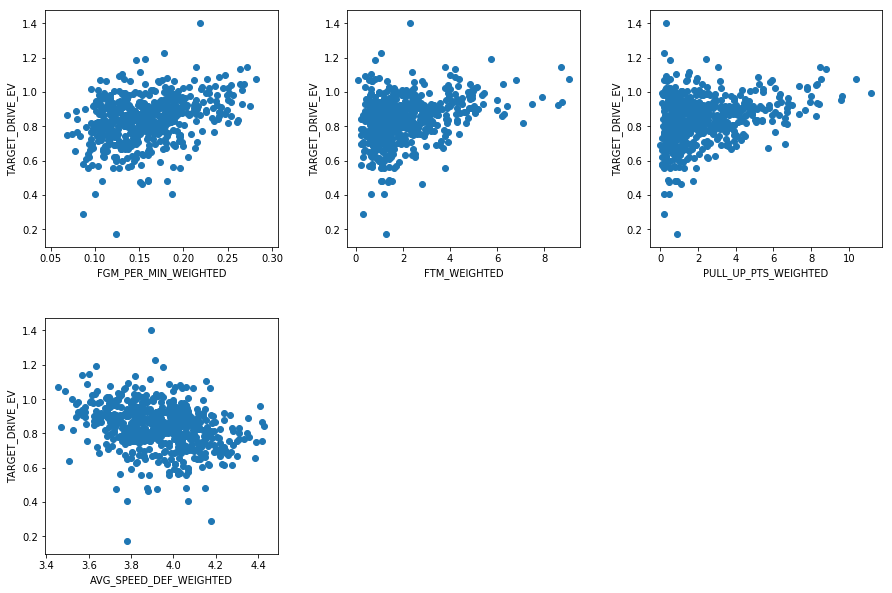

In [13]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

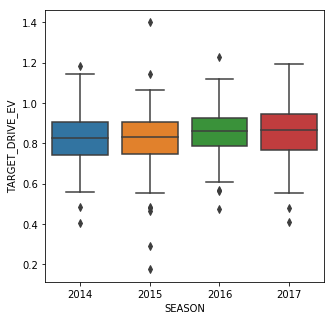

In [14]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

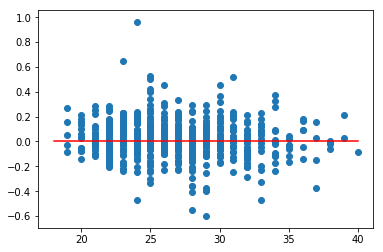

In [98]:
plt.scatter(X_train['AGE'], y_train['TARGET_DRIVE_EV'] - X_train['DRIVE_EV'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used season features multiple times...
- Used a lot of distance measures.
- Did not perform very well.

In [15]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

12

In [16]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['SEASON', 'DIST_MILES_PER_MIN', 'DIST_MILES_OFF_PER_MIN',
       'DIST_MILES_DEF_PER_MIN', 'OPEN_FGM_PER_MIN', 'OPEN_FG3M_PER_MIN',
       'DIST_MILES_PER_MIN_WEIGHTED', 'DIST_MILES_OFF_PER_MIN_WEIGHTED',
       'DIST_MILES_DEF_PER_MIN_WEIGHTED', '2015', '2016', '2017'],
      dtype='object')

In [17]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.01977557335320801

#### K BEST
- The 6 feature model seemed the best.
- The model also really struggled.

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

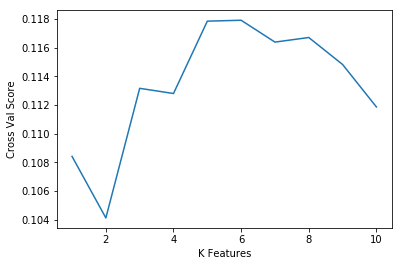

In [41]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 11):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1,11), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarni

5  Feature Cross Val Scores:  [0.02547053 0.14380517 0.08770967 0.18914818 0.14306977]
6  Feature Cross Val Scores:  [0.02684739 0.14330236 0.08593554 0.18997073 0.14346801]
7  Feature Cross Val Scores:  [0.04187589 0.12455446 0.05889503 0.20316464 0.15341063]
8  Feature Cross Val Scores:  [0.04869015 0.09930761 0.07075256 0.20221709 0.16253486]
9  Feature Cross Val Scores:  [0.0498045  0.08590519 0.07107846 0.20323902 0.16406572]


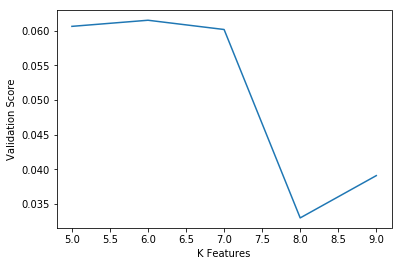

In [42]:
# Checking out 5 - 9 features
k_scores = []
for k in range(5, 10):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(5, 10), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [43]:
# Printing out the scores with 6 features
k_best = SelectKBest(f_regression, k=6)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:292: RuntimeWarning: invalid value encountered in sqrt
  n_samples * X_means ** 2)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/envs/dsi/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


0.06148834871565234

In [44]:
# Printing the model features
model_features

['POINTS',
 'FGM_PER_MIN',
 'FGM_PG_PER_MIN',
 'POINTS_WEIGHTED',
 'FGM_PER_MIN_WEIGHTED',
 'FGM_PG_PER_MIN_WEIGHTED']

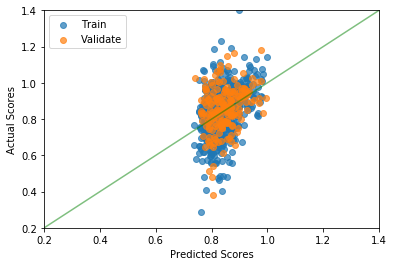

In [48]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_min=.2,
              axis_max=1.4)

#### PCA
- The model performed decently, but a fold in the cross-validation was much different.
- 2 features were chosen using the elbow method.

In [133]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.2831037 , 0.1885406 , 0.08559261, 0.04347306, 0.03350134,
       0.02244948, 0.02123588, 0.0192834 , 0.01610743, 0.01570852,
       0.01370262, 0.01243959, 0.01024618, 0.00982906, 0.00896944])

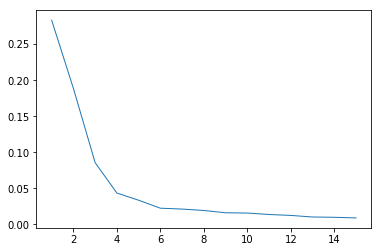

In [135]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [136]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.03912691, 0.08244152, 0.12658418, 0.2075682 , 0.1495357 ])

In [139]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.09124619236831655

#### Neural Net
- There predicted scores are very narrow.
- The model had a negative score.

In [49]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [50]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [51]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [52]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

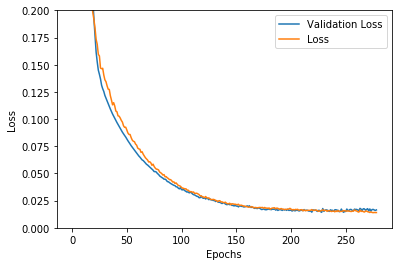

In [53]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [54]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

-0.13509943359508236

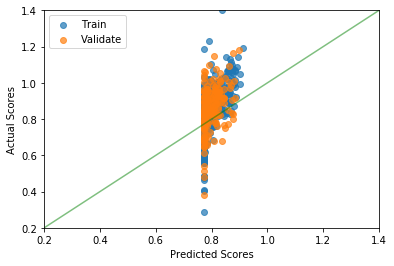

In [55]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_min=.2, axis_max=1.4)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into expected value, and features that I wanted to experiment with.
- The scores seem better than the other models.
- The graph looks much better. The variance along the predicted scores more closely matches the variance of the actual scores.

In [112]:
# Saving the model features
model_features = ['PULL_UP_EV_WEIGHTED', 'FT_PCT_WEIGHTED', 'DRIVE_AST_PCT_WEIGHTED', 'DRIVE_FGA_PER_MIN_WEIGHTED',
                  'DRIVE_TOV_PCT_WEIGHTED', 'DRIVE_PTS_PCT_WEIGHTED', 'DRIVE_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES',
                  'SKINNY', 'AGE', '2015', '2016', '2017', 'AST_TO_WEIGHTED', 'TIGHT_FG2_PCT', 'VERY_TIGHT_FG2_PCT']

In [138]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.13611171, 0.11381781, 0.01869571, 0.23714666, 0.31920114])

In [114]:
# Checking the validation score
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.118193807832917

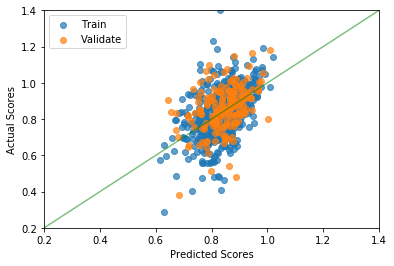

In [115]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_min=.2,
              axis_max=1.4)

#### Regularized Linear Regression with My Selected Features
- These scores are much improved from the linear regression.
- The lasso predictions are very narrow.
- They both suffer from having the same over predicting low values and under predicting high values problem.
- They both really valued assist to turnover values and scoring on drives.

In [116]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [117]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.15766777, 0.1233257 , 0.04560351, 0.21814529, 0.29999143])

In [118]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.13185234949852942

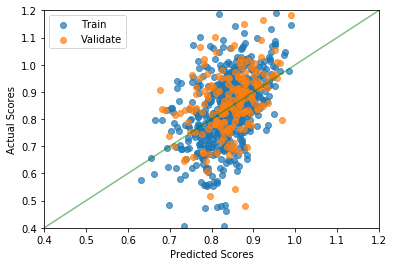

In [119]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_min=.4, axis_max=1.2)

In [120]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.13442137, 0.10882611, 0.04835096, 0.14207394, 0.1983578 ])

In [121]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.1183324975361012

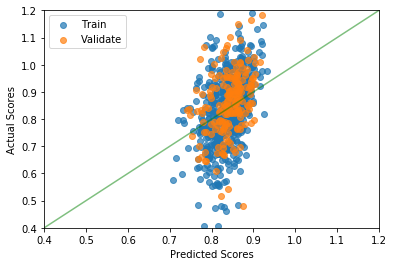

In [122]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_min=.4, axis_max=1.2)

In [123]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
PULL_UP_EV_WEIGHTED,0.010186,0.014661
FT_PCT_WEIGHTED,0.014276,0.019127
DRIVE_AST_PCT_WEIGHTED,0.000000,0.010887
DRIVE_FGA_PER_MIN_WEIGHTED,0.000000,0.004025
DRIVE_TOV_PCT_WEIGHTED,-0.007370,-0.007947
DRIVE_PTS_PCT_WEIGHTED,0.018158,0.028901
DRIVE_RATE_WEIGHTED,0.008432,0.015740
PLAYER_HEIGHT_INCHES,0.000000,0.017243
SKINNY,-0.000000,-0.004998
AGE,-0.000000,-0.007206


#### Final scores (Ridge)
- The r2 score on the test set was relatively high compared to many of the models' cross validation scores.
- 12.8% percent improvement over baseline predictions on the test set.

In [124]:
# Ridge score on test data
X_test_scaled = scaler.transform(X_test[model_features])
ridge.score(X_test_scaled, y_test)

0.15649501765543317

In [125]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.14251531505383322

In [126]:
# The score if the prediction was just the value from the current year
baseline = mean_squared_error(y_test, X_test['DRIVE_EV']) ** .5
baseline

0.1634293341144259

In [127]:
# Looking at the percent improvement
1 - rmse/baseline

0.12796979914235973

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [110]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_DRIVE_EV'] = ridge.predict(X_train_scaled)

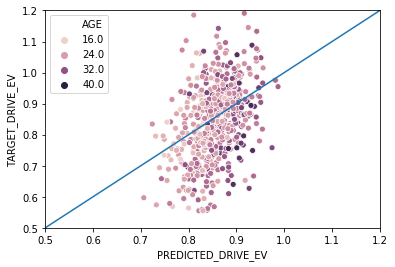

In [111]:
sns.scatterplot('PREDICTED_DRIVE_EV', 'TARGET_DRIVE_EV', data=train, hue='AGE')
plt.plot([0,1.2], [0,1.2])
plt.xlim(.5, 1.2)
plt.ylim(.5, 1.2);